<a href="https://colab.research.google.com/github/Abhinav-gh/OCR_Grid_2024/blob/main/OCR_Gemini_on_real_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install google-generativeai
!pip install paddleocr
!pip install paddlepaddle


In [ ]:
import google.generativeai as genai
from google.colab import userdata
from paddleocr import PaddleOCR
from PIL import Image

# Set up Gemini API
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize OCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Adjust language if needed

# Function to extract text from the image
def extract_text_from_image(image_path):
    img = Image.open(image_path)
    result = ocr.ocr(image_path, cls=True)
    try:
      extracted_text = "\n".join([line[1][0] for line in result[0]])
    except:
      print(f"[DEBUG] OCR Result: {result}")
    print(f"[DEBUG] Extracted Text:\n{extracted_text}")
    return extracted_text

# Function to classify extracted text using Gemini API
def classify_text_with_gemini(text):
    model = genai.GenerativeModel('models/gemini-1.5-flash')
    # Update the prompt to specifically ask for manufacturing and expiration dates
    response = model.generate_content(f"Analyze the following text and extract both the manufacturing and expiration dates. The text may contain unclear or partially obscured information, and dates may not be on the same line. Please provide the extracted dates in the format: Manufacturing Date, Expiration Date. If a date is missing, replace it with -1. The text is: {text}")
    print(f"[DEBUG] Gemini Response:\n{response.text}")
    return response.text

# Main processing function
def process_image(image_path):
    # Extract text from the image
    extracted_text = extract_text_from_image(image_path)

    # Classify text using Gemini API
    classified_result = classify_text_with_gemini(extracted_text)

    return classified_result

# Example usage
image_path = "sample_img2.jpg"  # Replace with your image path
result = process_image(image_path)
print(f"[DEBUG] Final Classification Result:\n{result}")


[2024/10/12 19:49:56] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

[2024/10/12 19:58:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

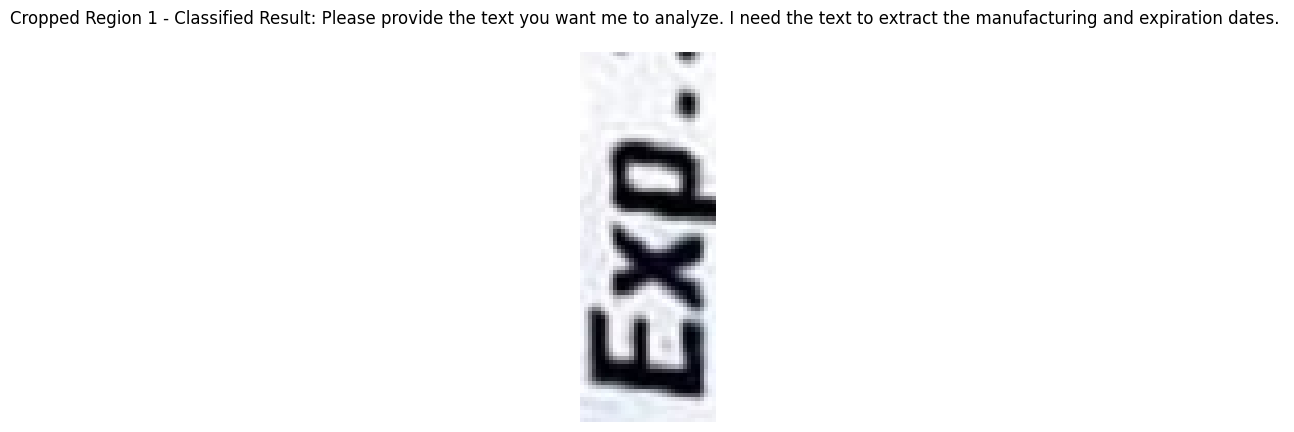

In [ ]:
import cv2
import matplotlib.pyplot as plt
import google.generativeai as genai
from paddleocr import PaddleOCR

# Initialize OCR with detection enabled
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Set up Gemini API
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

def classify_dates_with_gemini(text):
    # Call the Gemini API to classify and extract dates
    model = genai.GenerativeModel('models/gemini-1.5-flash')
    response = model.generate_content(
        f"Analyze the following text and extract both the manufacturing and expiration dates: {text}. "
        "If a date is missing, use -1 as a placeholder."
    )
    return response.text

def detect_and_crop_date_region(image_path):
    # Read image using OpenCV
    img = cv2.imread(image_path)

    # Use PaddleOCR to detect text regions
    result = ocr.ocr(image_path, cls=True)

    # Find regions with potential keywords like 'MFD', 'EXP', etc.
    date_boxes = []
    for line in result[0]:
        text = line[1][0].lower()  # Convert to lowercase for keyword matching
        if any(keyword in text for keyword in ['exp', 'expiry', 'mfd', 'best before']):
            date_boxes.append((line[0], text))  # Store the bounding box and text

    # Crop the identified regions, classify them with Gemini, and display
    classified_dates = []
    for idx, (box, text) in enumerate(date_boxes):
        # Convert coordinates to integers
        x1, y1 = int(box[0][0]), int(box[0][1])
        x2, y2 = int(box[2][0]), int(box[2][1])
        cropped = img[y1:y2, x1:x2]  # Crop the region

        # Classify the cropped region with the Gemini API
        classified_result = classify_dates_with_gemini(text)
        classified_dates.append((classified_result, cropped))

        # Display the cropped region with classified result
        plt.figure()
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title(f"Cropped Region {idx + 1} - Classified Result: {classified_result}")
        plt.axis('off')
        plt.show()

    return classified_dates

# Example usage
image_path = 'sample_img2.jpg'  # Replace with your image path
cropped_regions = detect_and_crop_date_region(image_path)


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # YOLOv5 repository
%cd yolov5
!pip install -r requirements.txt paddleocr


Cloning into 'yolov5'...
remote: Enumerating objects: 16982, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 16982 (delta 90), reused 110 (delta 54), pack-reused 16805 (from 1)
Receiving objects: 100% (16982/16982), 15.71 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (11628/11628), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.7/882.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
import torch
from paddleocr import PaddleOCR
import cv2

# Initialize OCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Load YOLOv5 model (you can train your custom model if needed)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # Use yolov5s.pt as a baseline

def detect_regions(image_path):
    # Run YOLOv5 on the input image
    results = model(image_path)
    results.print()
    results.save()  # Save detected results for visualization

    # Extract detected regions
    return results.pandas().xyxy[0]  # Dataframe with bounding boxes and labels


[2024/10/12 19:58:56] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-10-12 Python-3.10.12 torch-2.4.1+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 162MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [ ]:
def ocr_and_analyze(image_path, bounding_boxes):
    img = cv2.imread(image_path)
    detected_texts = []

    for idx, row in bounding_boxes.iterrows():
        # Extract bounding box coordinates
        x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        cropped = img[y1:y2, x1:x2]

        # Apply OCR to the cropped region
        result = ocr.ocr(cropped, cls=True)
        text = "\n".join([line[1][0] for line in result[0]])
        detected_texts.append((text, (x1, y1, x2, y2)))

    return detected_texts


In [ ]:
def classify_dates(detected_texts):
    mfg_date, exp_date = None, None

    # Check each detected text for keywords and context
    for text, bbox in detected_texts:
        if any(keyword in text.lower() for keyword in ['mfd', 'manufactured']):
            mfg_date = text
        elif any(keyword in text.lower() for keyword in ['exp', 'expiry', 'best before']):
            exp_date = text

    return mfg_date, exp_date


In [45]:
import matplotlib.pyplot as plt
from PIL import Image  # Import Image from the Pillow library

# Function to draw bounding boxes and show text
def draw_bounding_boxes(image_path):
    # Read the image
    img = Image.open(image_path)
    result = ocr.ocr(image_path, cls=True)  # Get the OCR result

    # Create a figure to display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()
    all_text_data = []
    # Iterate through the results and draw boxes
    for idx, line in enumerate(result[0]):
        box = line[0]  # Get the bounding box coordinates
        text = line[1][0]  # Extracted text
        print(f"[DEBUG] Box {idx + 1}: {text}")  # Display text with box number
        all_text_data.append(f"{text}")

        # Draw the bounding box
        polygon = plt.Polygon(box, fill=None, edgecolor='red', linewidth=2)
        ax.add_patch(polygon)
        # Add text label in the box
        # ax.text(box[0][0], box[0][1] - 5, f"{idx + 1}: {text}", color='blue', fontsize=12)

    plt.axis('off')  # Hide axes
    plt.show()
    return all_text_data



In [33]:
import google.generativeai as genai
from google.colab import userdata

# Set your API key securely (store it in Colab’s userdata)
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')  # Replace with your API Key if needed
genai.configure(api_key=GOOGLE_API_KEY)

def gemini_context_correction(text):
    """Use Gemini API to refine noisy OCR results."""
    model = genai.GenerativeModel('models/gemini-1.5-flash')
    response = model.generate_content(
            f"Identify and refine the manufacturing and expiration dates from the following text. "
            f"The dates may be written in dd/mm/yyyy format or as <Month_name> <Year> or <day> <Month_Name> <Year>"
            f"The text may contain noise or unclear information. If only one date is provided, "
            f"consider it as the Expiration Date. Format the output as: "
            f"Manufacturing Date: <MFG Date>, Expiration Date: <EXP Date>. "
            f"Here is the text: {text}"
        )
    return response.text

# Test Gemini with example text (replace with actual OCR output)
sample_text = "EXP 12/2024 MFD 08/2023 Best Before 06/2025"
refined_output = gemini_context_correction(sample_text)
print("[DEBUG] Gemini Refined Output:\n", refined_output)


[DEBUG] Gemini Refined Output:
 Manufacturing Date: 08/2023, Expiration Date: 12/2024 



In [34]:
def validate_dates_with_gemini(mfg_date, exp_date):
    """Use Gemini API to validate and correct the manufacturing and expiration dates."""
    model = genai.GenerativeModel('models/gemini-1.5-flash')
    response = model.generate_content(
        f"Please provide the final Manufacturing Date and Expiration Date based on the following: "
        f"Manufacturing Date: {mfg_date}, Expiration Date: {exp_date}. "
        f"Based on these dates, can you check if they are logically correct. If the expiry is less than mfg then they need to be swapped. "
        f"Also, if the dates seem to be logically incorrect, decide what could be the possible date. When returning any output, just return the dates in the format: "
        f"Manufacturing Date: <MFG Date>, Expiration Date: <EXP Date>. Nothing else at all"
        f"If a date is '-1', it means it doesn't exist, so leave it unchanged."
    )

    # Check if the response contains valid parts
    if response.parts:
        # Process the response to extract final dates
        final_dates = response.parts[0].text.strip()
        return final_dates

    # Return a message or a default value if no valid parts are found
    return "Invalid response from Gemini API."



def extract_date(refined_text, date_type):
    """Extract the specified date type from the refined text."""
    if date_type in refined_text:
        try:
            # Split the text and find the date for the specified type
            parts = refined_text.split(',')
            for part in parts:
                if date_type in part:
                    return part.split(':')[1].strip()  # Return the date value
        except IndexError:
            return '-1'  # Return -1 if the date is not found
    return '-1'  # Return -1 if the date type is not in the text



Saving IMG-20241013-WA0005.jpg to IMG-20241013-WA0005 (1).jpg
[2024/10/13 11:56:26] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_

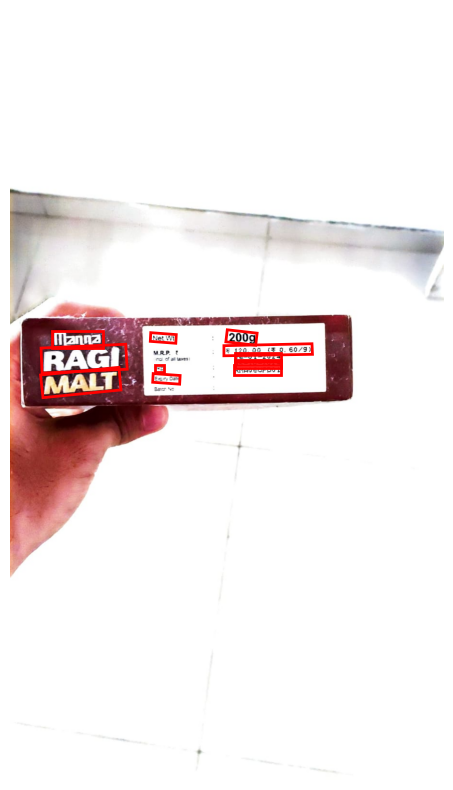

[DEBUG]  ['Box 1: Manna', 'Box 2: Net.Wt', 'Box 3: 200g', 'Box 4: RAGI', 'Box 5: 120.000.60/9', 'Box 6: 06-01-2024', 'Box 7: 05-10-2024', 'Box 8: PKD', 'Box 9: RMA06UFD01', 'Box 10: MALT', 'Box 11: Esry Date'] <class 'list'>
[DEBUG] combined tect Manna
200g
Net.Wt
.
RAGI
M.R.P.
120.000.60/9
da taxes
06-01-2024
PXD
05-10-2024
RMAOEUFD01
MALT
Ecry Date
SaNo
Box 1: Manna
Box 2: Net.Wt
Box 3: 200g
Box 4: RAGI
Box 5: 120.000.60/9
Box 6: 06-01-2024
Box 7: 05-10-2024
Box 8: PKD
Box 9: RMA06UFD01
Box 10: MALT
Box 11: Esry Date

[DEBUG] Gemini Refined Text:
 Manufacturing Date: 06-01-2024, Expiration Date: 05-10-2024 

[DEBUG] Validated Output from Gemini:
 Manufacturing Date: 06-01-2024, Expiration Date: 05-10-2024


In [57]:
import cv2
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
from google.colab import files

# Upload the image in Colab and retrieve the path dynamically
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Dynamically get the uploaded filename

# Initialize PaddleOCR with detection enabled
ocr = PaddleOCR(use_angle_cls=True, lang='en')

def detect_and_analyze_regions(image_path):
    # Load the image and handle possible errors
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not load image at {image_path}. Check the path or format.")

    height, width, _ = img.shape
    part_height = height // 3
    ocr_results = []

    # Process the image in 3 vertical parts
    for i in range(3):
        y1, y2 = i * part_height, (i + 1) * part_height if i < 2 else height
        region = img[y1:y2, :]

        # Perform OCR on the region
        result = ocr.ocr(region, cls=True)
        if result and result[0]:  # Ensure there are valid results
            text_data = "\n".join([line[1][0] for line in result[0]])
            ocr_results.append(text_data)
        else:
            print(f"[DEBUG] No text detected in Region {i + 1}")

    # Combine all OCR text from the regions
    if ocr_results:
        combined_text = " ".join(ocr_results)+"\n"
        bounding_boxes_list= draw_bounding_boxes(image_path)
        print("[DEBUG] ",bounding_boxes_list, type(bounding_boxes_list))

        for text in bounding_boxes_list:
          combined_text += text
          combined_text += "\n"
        print("[DEBUG] combined tect", combined_text)
        # print("Combined Text\n", combined_text)
        # Send the combined text to Gemini for correction/analysis
        refined_text = gemini_context_correction(combined_text)
        print("[DEBUG] Gemini Refined Text:\n", refined_text)

        # Validate and correct dates
        mfg_date = extract_date(refined_text, "Manufacturing Date")
        exp_date = extract_date(refined_text, "Expiration Date")
        # Validate the dates using Gemini
        validated_output = validate_dates_with_gemini(mfg_date, exp_date)
        print("[DEBUG] Validated Output from Gemini:\n", validated_output)

        return final_output
    else:
        print("[DEBUG] No text detected in any of the regions.")
        return None

# Example usage
final_output = detect_and_analyze_regions(image_path)

# Example usage
